In [47]:
from keras_unet.models import custom_unet
from tensorflow import keras
from sklearn.model_selection import KFold
import mlflow
import os
import numpy as np
import keras_unet
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

# Get targets and labels

In [32]:
working_directory = os.getcwd()
target_directory = f'{working_directory}/data_360/images/'
label_directory = f'{working_directory}/labels/SegmentationClass'

target_filenames_for_check = os.listdir(target_directory)
label_filenames = os.listdir(label_directory)

n_targets = len(target_filenames_for_check)
n_labels = len(label_filenames)

labels_found = 0
labels_not_found = 0
for label_filename in label_filenames:
    if label_filename.replace('.png', '.JPG') in target_filenames_for_check:
        labels_found += 1
    else:
        labels_not_found += 1

print(f'Number of target images: {n_targets}')
print(f'Number of labels: {n_labels}')
print(f'Target images corresponding to labels found: {labels_found}, not found: {labels_not_found}')

target_filepaths = [ f'{target_directory}/{label_filename.replace(".png", ".JPG")}' for label_filename in label_filenames]
label_filepaths = [ f'{label_directory}/{label_filename}' for label_filename in label_filenames]

Number of target images: 10867
Number of labels: 233
Target images corresponding to labels found: 233, not found: 0


### Sanity check

In [70]:
test_target_image = Image.open(target_filepaths[3])
test_label_image = Image.open(label_filepaths[3])
print(f'Target image dimensions: {test_target_image.size[0]} x {test_target_image.size[1]}')
print(f'Label image dimensions: {test_label_image.size[0]} x {test_label_image.size[1]}')

Target image dimensions: 5760 x 2880
Label image dimensions: 5760 x 2880


In [71]:
test_target_numpy = np.asarray(test_target_image)
test_label_numpy = np.asarray(test_label_image)
print(f'Target image value range: ({test_target_numpy.min()}, {test_target_numpy.max()})')
print(f'Label image value range: ({test_label_numpy.min()}, {test_label_numpy.max()})')

Target image value range: (0, 255)
Label image value range: (0, 245)


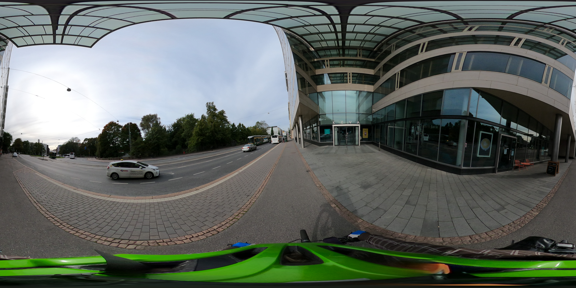

In [72]:
test_target_image.resize((576, 288))

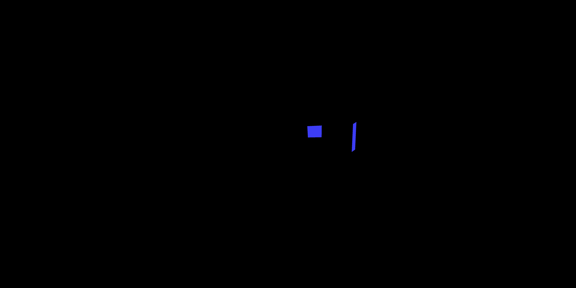

In [73]:
test_label_image.resize((576, 288))

# Train/Validation split and Data generator
Let's start with naive train/validation split and later build it into a proper K-fold Cross Validation scheme

### TODO: K-fold Cross Validation

In [230]:
n_validation_images = len(label_filepaths) // 10
n_train_images = len(label_filepaths) - n_validation_images
print(f'Training set size: {n_train_images}, validation set size: {n_validation_images}')

partition = {
    'train': label_filenames[0 : 10],
    'validation': label_filenames[n_train_images :]
}

print(f'Partition sizes: train={len(partition["train"])}, validation={len(partition["validation"])}') 

for filename in partition['train']:
    if filename in partition['validation']:
        print(f'Indexing error, file {filename} is in both training and validation sets')


Training set size: 210, validation set size: 23
Partition sizes: train=10, validation=23


In [ ]:
keras.utils.to_categorical(np.array([0, 1, 0, 2, 0, 2, 2]), num_classes=3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### TODO: 
    - patch images
    - image augmentation

In [423]:
class DataGenerator(keras.utils.Sequence):
    """
        Generate augmented (target, label) pairs for Keras.
    """
    def __init__(
        self, 
        list_IDs,
        target_directory,
        label_directory,
        label_rgbs,
        img_dimensions=(512, 512),
        n_channels=3,
        batch_size=4,
        shuffle=True
    ):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.num_target_classes = len(label_rgbs)
        self.img_dimensions = img_dimensions
        self.n_channels = n_channels
        self.target_directory = target_directory
        self.label_directory = label_directory
        self.label_rgbs = label_rgbs
        self.label_onehot = self.label_onehot_from_label_rgbs(label_rgbs)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """
            Number of batches per epoch
        """
        n_images = len(self.list_IDs)
        return int(np.ceil(n_images / self.batch_size))
    
    def __getitem__(self, index):
        """
            Generate one batch
        """
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        indexes = self.indexes[start : end]
        next_list_IDs = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation__(next_list_IDs, index)
        return X, y
    
    def rgb_to_onehot(self, img):
        """
            @img = M*N*Channels (e.g. 512 * 512 * 3 for a 512x512 pixel RGB image) numpy array
        """
        layout_x, layout_y, _ = img.shape
        layout = np.zeros((layout_x, layout_y, len(self.label_onehot[0])))
        for i, label in enumerate(self.label_rgbs):
            layout[np.all(img == label, axis = -1)] = self.label_onehot[i]
        return layout

    def label_onehot_from_label_rgbs(self, labels):
        layout = []
        size = len(labels)
        k = 0
        for i in range(0, size):
            vec = [0] * size
            for j in range(0, size):
                if j == k:
                    vec[j] = 1
            k += 1
            layout.append(vec)
        return layout

        
    def __data_generation__(self, next_list_IDs, index):
        cur_batch_size = self.batch_size
        
        # last batch might not be a full batch
        targets_remaining_in_epoch = len(self.list_IDs) - (index * self.batch_size)
        if targets_remaining_in_epoch < self.batch_size:
            cur_batch_size = targets_remaining_in_epoch
            
        X = np.empty((cur_batch_size, *self.img_dimensions, self.n_channels))
        y = np.empty((cur_batch_size, *self.img_dimensions, self.num_target_classes))
        
        for i, id in enumerate(next_list_IDs):
            target_filepath = f'{self.target_directory}/{label_filename.replace(".png", ".JPG")}'
            label_filepath = f'{self.label_directory}/{label_filename}'
            patches = keras_unet.utils.patches(
            X[i,] = np.asarray(Image.open(target_filepath)) / 255
            label = np.asarray(Image.open(label_filepath))
            y[i,] = self.rgb_to_onehot(label)
        return X, y
    
    def on_epoch_end(self):
        """
            Update indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    

### Test data generator

In [494]:
label_rgbs = {
    "background": [0,0,0],
    "porras": [255,106,77],
    "portti": [51,221,255],
    "porttikäytävä": [255,204,51],
    "rapputunnus": [131,224,112],
    "sisäänkäynti": [61,61,245],
}

data_generator = DataGenerator(
    list_IDs = partition["train"],
    target_directory = target_directory,
    label_directory = label_directory,
    label_rgbs = list(label_rgbs.values()),
    img_dimensions=(2880, 5760),
    batch_size=1
)

gen = data_generator.__iter__()

In [480]:
vals = next(gen)

In [483]:
X, y = vals
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X min, max: {np.min(X), np.max(X)}')
print(f'y min, max: {np.min(y), np.max(y)}')


X shape: (2, 2880, 5760, 3)
y shape: (2, 2880, 5760, 6)
X min, max: (0.0, 1.0)
y min, max: (0.0, 1.0)


In [495]:
model = custom_unet(
    input_shape=(None, None, 3),
    use_batch_norm=True,
    num_classes=len(label_rgbs),
    filters=64,
    dropout=0.2,
    output_activation='softmax')

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.MeanIoU(num_classes=len(label_rgbs))
    ]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_57 (Conv2D)             (None, None, None,   1728        ['input_4[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_54 (BatchN  (None, None, None,   256        ['conv2d_57[0][0]']              
 ormalization)                  64)                                                         

In [492]:
mlflow.tensorflow.autolog() # automatically log for mlflow tracking
mlflow.log_param('phase', 'testing')

In [496]:

model.fit_generator(generator=data_generator)

/tmp/ipykernel_17055/1819154958.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=data_generator)
2021-12-10 23:37:24.745613: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-12-10 23:37:25.477719: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-10 23:37:25.559233: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-10 23:37:37.049184: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.96GiB (rounded to 4246732800)requested by op model_3/conv2d_58/Conv2D
If the c

ResourceExhaustedError: 2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[1,64,2880,5760] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/conv2d_58/Conv2D
 (defined at /home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py:231)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_59]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[1,64,2880,5760] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/conv2d_58/Conv2D
 (defined at /home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py:231)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_12693]

Errors may have originated from an input operation.
Input Source operations connected to node model_3/conv2d_58/Conv2D:
In[0] model_3/spatial_dropout2d_15/dropout/Mul_1 (defined at /home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/core/dropout.py:105)	
In[1] model_3/conv2d_58/Conv2D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_17055/1819154958.py", line 1, in <module>
>>>     model.fit_generator(generator=data_generator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 546, in safe_patch_function
>>>     patch_function.call(call_original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 168, in call
>>>     return cls().__call__(original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 172, in __call__
>>>     return self._patch_implementation(original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 230, in _patch_implementation
>>>     result = super(PatchWithManagedRun, self)._patch_implementation(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/tensorflow/__init__.py", line 890, in _patch_implementation
>>>     history = original(inst, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 529, in call_original
>>>     return call_original_fn_with_event_logging(_original_fn, og_args, og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 471, in call_original_fn_with_event_logging
>>>     original_fn_result = original_fn(*og_args, **og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 526, in _original_fn
>>>     original_result = original(*_og_args, **_og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

Input Source operations connected to node model_3/conv2d_58/Conv2D:
In[0] model_3/spatial_dropout2d_15/dropout/Mul_1 (defined at /home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/core/dropout.py:105)	
In[1] model_3/conv2d_58/Conv2D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_17055/1819154958.py", line 1, in <module>
>>>     model.fit_generator(generator=data_generator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 546, in safe_patch_function
>>>     patch_function.call(call_original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 168, in call
>>>     return cls().__call__(original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 172, in __call__
>>>     return self._patch_implementation(original, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 230, in _patch_implementation
>>>     result = super(PatchWithManagedRun, self)._patch_implementation(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/tensorflow/__init__.py", line 890, in _patch_implementation
>>>     history = original(inst, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 529, in call_original
>>>     return call_original_fn_with_event_logging(_original_fn, og_args, og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 471, in call_original_fn_with_event_logging
>>>     original_fn_result = original_fn(*og_args, **og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py", line 526, in _original_fn
>>>     original_result = original(*_og_args, **_og_kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/home/emblica/.pyenv/versions/3.8.12/envs/forum-virium-3.8.12/lib/python3.8/site-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

Function call stack:
train_function -> train_function
